<a href="https://colab.research.google.com/github/shubh-tiwari/Predicting-Credit-Card-Approval/blob/master/Switchon_defect_detection_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Deep learning based solution to differentiate and visualize the defected region**

The following steps used to detect the defect and visualize the defect:
    
    1. Defining user inputs
      a) Input image size for xception architecture
      b) Similarity threshold (If below 0.25, it is defect)
      c) Window size for sliding window algorithm
      d) Stride to jump for next window
    
    2. Process flow
      a) Sliding window algorithm is used to traverse the both good and defected image
      b) Feature vectors are extracted using pre-trained Xception model
      c) Cosine similarity is calculated between two feature vectors
      d) Non-min suppression (inspired from non-max suppression algorithm) is used to extract out the best rectangle
      e) Highlight the defect

    3. Testing on an augmented image
      a) An augmented defect image is created by adding rusting at two places
      b) The process flow is tested on this augmented image

In [ ]:
"""IMPORT LIBRARIES"""
import os
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from tensorflow.python.keras.applications.xception import Xception, preprocess_input
from tensorflow.python.keras.preprocessing import image as process_image
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras import Model

In [ ]:
"""IMPORTANT USER INPUTS"""
# These user inputs are important to get required result
# Changing these values can detect any new defect

# Input image size for xception architecture
input_img_shape = (150, 150, 3)

# Similarity threshold (ranges between 0 to 1). Below 0.25, it is considered as defect here
similarity_thresh = 0.25

# Window size for sliding window algorithm
patch_size = 70

# Stride value to jump over for the new window
stride = 30

In [ ]:
"""Function definitions"""

def cosine_distance(feature1, feature2):
    """Function to find cosine similarity"""
    return np.dot(feature1, feature2.T) / \
            np.dot(np.linalg.norm(feature1, axis=1, keepdims=True), \
            np.linalg.norm(feature2.T, axis=0, keepdims=True))

def preprocess(img_to_preprocess, input_img_shape):
    """Function to reprocess the image for prection"""
    resize_shape = (input_img_shape[0], input_img_shape[1])
    resized_img = cv2.resize(img_to_preprocess, resize_shape, interpolation = cv2.INTER_LINEAR)
    preprocess_img = np.expand_dims(resized_img, axis=0)
    preprocess_img = preprocess_input(preprocess_img)
    
    return preprocess_img

def highlight_roi(img, boxes):
    """Highlighting the roi in image"""
    for box in boxes:
        cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), thickness=5)
    return img

def filter_roi(similarity, boxes, overlapThresh=0.1):
    """Filtering the correct rectangle using non-min suppression"""
    picks = []
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
        
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    indices = similarity.argsort()
    while indices.size > 0:
        picks.append(indices[0])
        
        xx1 = np.maximum(x1[indices[0]], x1[indices[1:]])
        yy1 = np.maximum(y1[indices[0]], y1[indices[1:]])
        xx2 = np.minimum(x2[indices[0]], x2[indices[1:]])
        yy2 = np.minimum(y2[indices[0]], y2[indices[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[indices[1:]]
        indices = np.delete(indices, np.append([0], np.where(overlap > overlapThresh)[0]+1))

    return boxes[picks].astype("int")

def defect_detection(good_img, bad_img, block, stride, similarity, boxes, input_img_shape, similarity_thresh):
    """Precting the region with defect using sliding window detection"""
    for i in range(0,bad_img.shape[0]-block,stride):
        for j in range(0,bad_img.shape[1]-block,stride):

            good_crop = good_img[i:i+block, j:j+block]
            good_features = model.predict(preprocess(good_crop, input_img_shape))

            bad_crop = bad_img[i:i+block, j:j+block]
            bad_features = model.predict(preprocess(bad_crop, input_img_shape))

            similarity_coeff = cosine_distance(good_features, bad_features)

            if similarity_coeff.item() < similarity_thresh:
                similarity = np.append(similarity, similarity_coeff.item())
                if boxes.size == 0:
                    boxes = np.reshape(np.array([i,j,i+block,j+block]), (1,4))
                else:
                    box = np.reshape(np.array([i,j,i+block,j+block]), (1,4))
                    boxes = np.concatenate((boxes, box), axis=0)
    
    return similarity, boxes

In [ ]:
# Defining Xception model pre-trained on ImageNet to extact feature vector
# include_top = False (To not include fully connected layers)
# input_shape is given by user

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_img_shape)
output = base_model.layers[-1].output
output = GlobalAveragePooling2D()(output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# Reading good image if its present in google colab, otherwise uploading the good image
if os.path.isfile('gimage.png'):
  print("Good image found and read successfuly.")
  good_image = cv2.imread('gimage.png')
else:
  from google.colab import files
  print("Choose the image with no defect")
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('Image with no defect: "{name}"'.format(name=fn))
    good_image = cv2.imread(fn)

Good image found and read successfuly.


In [ ]:
# Reading bad image if its present in google colab, otherwise uploading the bad image
if os.path.isfile('bimage.png'):
  print("Defected image found and read successfuly.")
  bad_image = cv2.imread('bimage.png')
else:
  from google.colab import files
  print("Choose the defected image")
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('Image with missing nut defect: "{name}"'.format(name=fn))
    bad_image = cv2.imread(fn)

Defected image found and read successfuly.


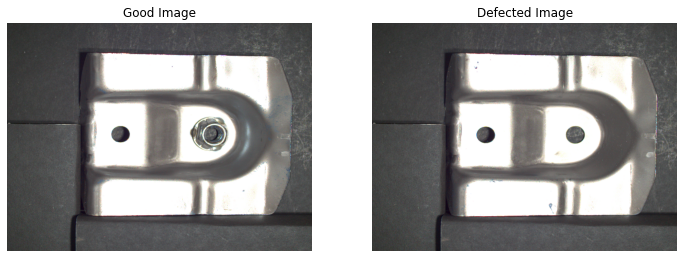

In [ ]:
# Plotting the good and defected image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

ax1.set_title("Good Image")
ax1.axis("off")
ax1.imshow(good_image)

ax2.set_title("Defected Image")
ax2.axis("off")
ax2.imshow(bad_image)

plt.show()

In [ ]:
similarity = np.array([])
boxes = np.array([])

# Defect detection using sliding window algorithm
similarity, boxes = defect_detection(good_image, bad_image, patch_size, stride, similarity, boxes, input_img_shape, similarity_thresh)

# Filtering out the best rectangle by using non-min suppression algorithm
filtered_boxes = filter_roi(similarity, boxes)

# Highlighing the defect
highlighted_bad_img = highlight_roi(bad_image.copy(), filtered_boxes)

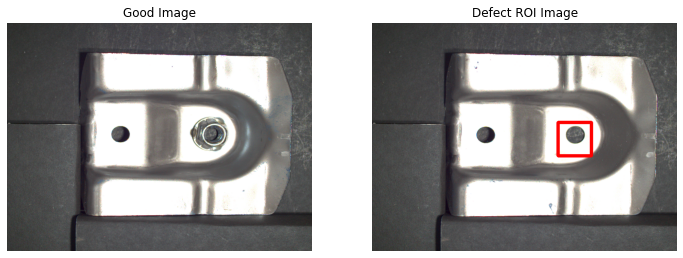

In [ ]:
# Plotting the good and defected image along with highlighted defect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

ax1.set_title("Good Image")
ax1.axis("off")
ax1.imshow(good_image)

ax2.set_title("Defect ROI Image")
ax2.axis("off")
ax2.imshow(highlighted_bad_img)

plt.show()

## **Testing the approach on an augmented image with two rusting defects**

In [ ]:
# Reading augmented bad image if its present in google colab, otherwise uploading the image
if os.path.isfile('augmented_bad_image.png'):
  print("Defected image found and read successfuly.")
  augmented_bad_image = cv2.imread('augmented_bad_image.png')
else:
  from google.colab import files
  print("Choose the augmented defected image")
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('Image with missing nut defect: "{name}"'.format(name=fn))
    augmented_bad_image = cv2.imread(fn)

Defected image found and read successfuly.


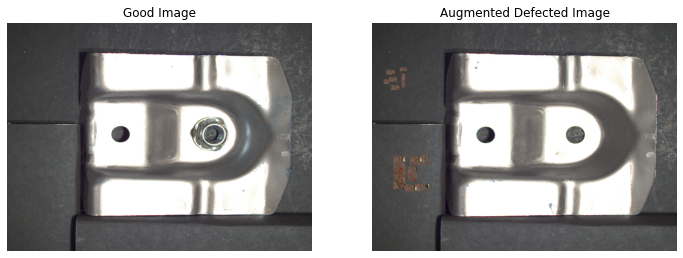

In [ ]:
# Plotting the good and augmented defect image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

ax1.set_title("Good Image")
ax1.axis("off")
ax1.imshow(good_image)

ax2.set_title("Augmented Defected Image")
ax2.axis("off")
ax2.imshow(augmented_bad_image)

plt.show()

In [ ]:
# Changing window size and strides for this case
patch_size = 90
stride = 10

similarity = np.array([])
boxes = np.array([])

# Defect detection using sliding window algorithm
similarity, boxes = defect_detection(good_image, augmented_bad_image, patch_size, stride, similarity, boxes, input_img_shape, similarity_thresh)

# Filtering out the best rectangle by using non-min suppression algorithm
filtered_boxes = filter_roi(similarity, boxes)

# Highlighing the defect
highlighted_bad_img = highlight_roi(augmented_bad_image.copy(), filtered_boxes)

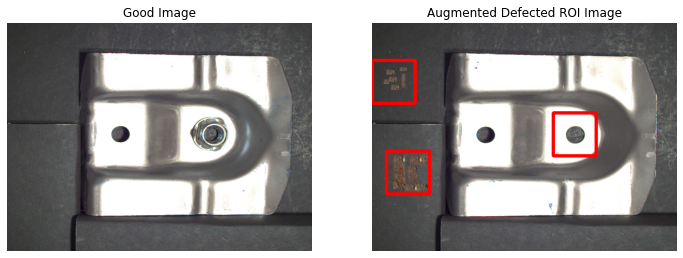

In [ ]:
# Plotting the good and augmented defect image along with highlighted defect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

ax1.set_title("Good Image")
ax1.axis("off")
ax1.imshow(good_image)

ax2.set_title("Augmented Defected ROI Image")
ax2.axis("off")
ax2.imshow(highlighted_bad_img)

plt.show()

In [ ]:
# Writing augmented defect image along with highlighted defect
cv2.imwrite("augmeneted_ROI.jpg", cv2.cvtColor(highlighted_bad_img, cv2.COLOR_RGB2BGR))

True